# 参考にしたブログ
https://www.st-hakky-blog.com/entry/2019/04/22/180619

# ※googlmapが表示されない方。
理由は、ブラウザが microsoft edgeだからです。右のリンクを参照して設定を変えましょう。
https://qiita.com/nsh1l/items/4bd7c6bbb3a2de49b91b

### c.NotebookApp.browser = u'\"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" %s --incognito'
### ↑↑シャープは消します

In [256]:
import math
from datetime import datetime, timedelta
import folium
import csv
import pandas as pd

In [374]:
#下準備
# 時刻を表示するときに、どういう文字列として表示するかを決めておく。細かい意味はstrftime等を参照
time_format = "%Y-%m-%d %H:%M:%S.%f"

# 度からラジアンに変換
def to_radian(degree):
    return float(degree) * math.pi / 180.0

# 緯度経度で与えられた2点間の距離を近似計算
def calc_distance(lat1, lng1, lat2, lng2):
    a = 6378137.000
    e2 = 0.00669437999019758
    mnum = 6335439.32729246
    lat1 = to_radian(lat1)
    lng1 = to_radian(lng1)
    lat2 = to_radian(lat2)
    lng2 = to_radian(lng2)
    my = (lat1 + lat2) / 2.0
    dy = lat1 - lat2
    dx = lng1 - lng2

    sin = math.sin(my)
    cos = math.cos(my)
    w = math.sqrt(1.0 - e2 * sin * sin)
    m = mnum / (w * w * w)
    n = a / w
    
    dym = dy * m
    dxncos = dx * n * cos
    
    return math.sqrt(dym * dym + dxncos * dxncos)

# ロケーション履歴の取得方法
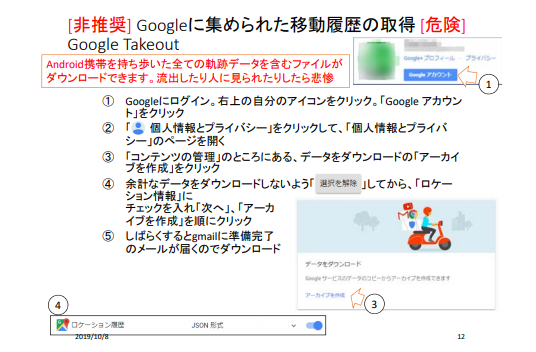

In [375]:
# ロケーション履歴を読み込むための下準備

import json
from pprint import pprint

# 整数値で記録された緯度経度を、浮動小数点数に変換
def convert_lat_lng(value):
    return value / 10e6

# jsonモジュールを使ってデータを読み込み
# ロケーション履歴が大きい場合、このセルは実行にすごく時間が掛かる
# このセルは最初に1回だけ実行して、読み込んだdataを使い回すと良い
with open("ロケーション履歴.json") as file:
    data = json.load(file)

# 記録されている項目名を表示
for keyname in data.keys():
    print(keyname)

locations


In [ ]:
# 以下でlocationsに履歴情報の配列が得られる
locations = data["locations"]

# 記録されている要素数を表示
print(len(locations))
# 最初の1個を表示してみる
pprint(locations[0])

In [425]:
# 指定した範囲のデータをマップにプロット

# いつからいつまでのデータをプロットするか
year = 2019
month = 9
day = 26
# 年月日、時刻を含んだ、最初の日時と、終了日時を設定
start_date = datetime(year, month, day, 22, 15)
end_date = datetime(year, month, day+1, 19, 20)

# 何かのミスで表示しようとする数が多すぎて破綻しないよう、扱うデータの個数の上限を決めておく
limit = 10000
count = 0

pre_lat = 0
pre_lng = 0

# マップを作成
map = folium.Map()

# 軌跡をプロットするためと、マップの表示範囲を決めるために、位置を記録していく配列positionsを用意
positions = []

# locationsの配列の中身を変数itemに入れて順にチェック
for item in locations:
    # itemからタイムスタンプ、緯度経度(lat、lng)、GPSの計測精度(accuracy)を取り出す
    timestamp = datetime.fromtimestamp(int(item["timestampMs"]) / 1000)
    lat = convert_lat_lng(item["latitudeE7"])
    lng = convert_lat_lng(item["longitudeE7"])
    accuracy = item["accuracy"]
 
    # 精度が閾値を越えているデータは読み飛ばす
    if accuracy > 16: 
        continue
    
    # タイムスタンプが指定された範囲外なら、そのitemは飛ばす
    # (continueは、このforループの、この周回では残りは実行せず、次の周回へ移れ、を意味する命令)
    if timestamp < start_date or end_date < timestamp:
        continue
    
    # 近すぎる点は、いらない。
    # スタート位置を(0, 0)とした相対座標を求める。単位は、メートルです！！
    meter = calc_distance(pre_lat, pre_lng, lat, lng)
    #距離が、1000ｍ以下の点は除外（近すぎる！）
    if meter < 1000:
        continue
    else:
        pre_lat = lat
        pre_lng = lng
    
    # foliumのマーカーを作成してmapに追加
    # マーカーのポップアップ(表示する文字列)は、時刻と、精度としておく
    folium.Marker(location=[lat, lng], popup=timestamp.strftime(time_format) + " : " + str(accuracy)).add_to(map)
    
    # positionsにも、位置情報を追加
    positions.append((lat, lng))
    
    # 個数が上限を超えていれば、そこでデータの取り出しを中止
    count += 1
    if count > limit:
        break

# positionsに記録したデータをポリライン(直線の組み合わせ)としてmapに追加することで、移動軌跡を表示        
folium.PolyLine(positions).add_to(map)

# fit_boundsを使うと、「配列として与えた座標一覧のマーカーが全部表示できるように、マップの表示範囲を調整せよ」と指示できる
map.fit_bounds(positions)

# mapを表示
map

In [426]:
positions
#(縦(経度), 横(緯度))

[(35.3146721, 136.2902146),
 (35.2733215, 136.2634081),
 (35.2773673, 136.2459038),
 (35.2761713, 136.256854),
 (35.2476911, 136.2497962),
 (35.1794253, 136.1649357)]

# ぐるなびとの連動
https://api.gnavi.co.jp/api/manual/

In [392]:
import requests
import time

# 口コミ応援

In [427]:
Url = "https://api.gnavi.co.jp/PhotoSearchAPI/v3/"
shop_dic = pd.DataFrame()
#パラメータの設定
for tate, yoko in positions:
    params={}
    params["keyid"] = "取得して下さい！" #取得したアクセスキー
    params["latitude"] = float(tate)
    params["longitude"] = float(yoko)
    params["range"] = 3 #1:300m、2:500m、3:1000m、4:2000m、5:3000m
    params["hit_per_page"] =50
    #リクエスト結果
    shop_dic = shop_dic.append(requests.get(Url, params).json(),ignore_index=True)
    time.sleep(1)

In [428]:
shops = pd.DataFrame()
dic_num = 0
times = 1
temp_rank = 0.0
temp_kome = ""
lastflag = False
for get in shop_dic["response"]:
    lastflag= False
    maxlen = len(shop_dic["response"][dic_num].keys())-5
    dic_num= dic_num + 1
    for i in range(maxlen+1):
        if i == maxlen:
            lastflag = True
        else:
            pass
    
        if lastflag == True:
            try:
                rank = float(get[str(i)]["photo"]["total_score"])
            except KeyError as e:
                rank = 2.0
            
            temp_s   = pd.DataFrame([[get[str(i)]["photo"]["shop_id"],
                                      get[str(i)]["photo"]["shop_name"],
                                     (temp_rank + rank)/times,
                                      temp_kome + get[str(i)]["photo"]["comment"] + "。"]])       
            shops = shops.append(temp_s)
            temp_rank = 0.0
            temp_kome = ""        
            times = 1
        elif (get[str(i)]["photo"]["shop_name"] != get[str(i+1)]["photo"]["shop_name"]):
            try:
                rank = float(get[str(i)]["photo"]["total_score"])
            except KeyError as e:
                rank = 2.0
            
            temp_s   = pd.DataFrame([[get[str(i)]["photo"]["shop_id"],
                                      get[str(i)]["photo"]["shop_name"],
                                     (temp_rank + rank)/times,
                                      temp_kome + get[str(i)]["photo"]["comment"] + "。"]])       
            shops = shops.append(temp_s)
            temp_rank = 0.0
            temp_kome = ""
            times = 1
        else:
            try:
                rank = float(get[str(i)]["photo"]["total_score"])
            except KeyError as e:
                rank = 2.0
            temp_rank = temp_rank + rank
            temp_kome = temp_kome + get[str(i)]["photo"]["comment"] + "。"
            times     = times + 1

In [429]:
shops[:15]

,0,1,2,3
0,3106583,ちゃんぽん亭総本家 彦根駅前本店,5.000000,あっさりで、これはこれで、美味！。
0,kak5803,肉割烹 柊家 はなれ彦根店,5.000000,大きな皿でやってきたメイン、\r\n氷が敷いてあったり、ガラスの皿等見た目にもこだわりを感じ...
0,kcjm124,丸亀製麺彦根松原店,3.500000,小鉢で1品食べて見ました。キノコの感触がお口のなかでこりこりと感じられました。。もうとろとろ...
0,7620655,Pomme d’Amour,3.500000,ランチはこれの他にも４、５種類あって、どれもお勧めですが、\r\nこのメンチカツランチは運ば...
0,7380406,美濠茶屋,4.000000,しつこくなくあっさりでかなり美味です(^0^)。全国的に有名になったバウムクーヘンです。焼き...
0,5055443,スイコー,3.000000,ダシのきいた甘いうどんのようなスープにラーメンを組み合わせた斬新なメニュー。
0,7331222,近江肉せんなり亭 伽羅,3.642857,とろける肉質がさすが近江牛と思った。比較的リーズナブルで満足。。。。口に入れたら、柔らかくジ...
0,5919667,うなぎや源内,4.000000,さあ、暑くなってきましたよ、うなぎを食べなくっちゃね！\r\nていうか、この季節になるとホン...
0,5753443,比内地鶏 ほっこりや,5.000000,玉子が半熟でとってもトロトロしていて、自分の中では今まで食べた親子丼の中で１番おいしいです！...
0,7331670,もんぜんや,3.083333,いなりに、少し甘しょっぱい味が、旨くしみこんだ感じでした。。冷たいそばを温かい鴨汁につけて食...


In [430]:
shops_sel = shops.copy()

In [431]:
#平均評価が、4.5点以下は除外。
shops_sel = shops_sel[shops_sel[2]>4.5]

In [432]:
#それぞれの点で、同じ店を抽出することも多々ある。よって、重複削除
shops_sel = shops_sel.drop_duplicates() 

In [433]:
shops_sel[:2]

,0,1,2,3
0,3106583,ちゃんぽん亭総本家 彦根駅前本店,5.0,あっさりで、これはこれで、美味！。
0,kak5803,肉割烹 柊家 はなれ彦根店,5.0,大きな皿でやってきたメイン、\r\n氷が敷いてあったり、ガラスの皿等見た目にもこだわりを感じ...


# 口コミをネガポジ分析して、口コミを数値化する！

In [434]:
#口コミの数値を入れる列を追加。
shops_sel[4] = 0

In [435]:
#★★ Janome 'Hello 蛇の目'★★
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.tokenfilter import *

import codecs

In [436]:
class CorpusElement:
    def __init__(self, text='', tokens=[], pn_scores=[]):
        self.text = text # テキスト本文
        self.tokens = tokens # 構文木解析されたトークンのリスト
        self.pn_scores = pn_scores # 感情極性値(後述)

# pn_ja.dicファイルから、単語をキー、極性値を値とする辞書を得る
def load_pn_dict():
    dic = {}
    
    with codecs.open('nega_poji.dic', 'r', 'UTF-8') as f:
        lines = f.readlines()
        
        for line in lines:
            # 各行は"良い:よい:形容詞:0.999995"
            columns = line.split(':')
            dic[columns[0]] = float(columns[3])
            
    return dic


# トークンリストから極性値リストを得る
def get_pn_scores(tokens, pn_dic):
    scores = []
    
    for surface in [t.surface for t in tokens if t.part_of_speech.split(',')[0] in ['形容詞']]:
        if surface in pn_dic:
            scores.append(pn_dic[surface])
        
    return scores

In [437]:
for i,texts in enumerate(shops_sel.iloc[:][3]):
    # CorpusElementのリスト
    naive_corpus = []
    naive_tokenizer = Tokenizer()
    tokens = naive_tokenizer.tokenize(texts)
    element = CorpusElement(texts, tokens)
    naive_corpus.append(element)   

    # 感情極性対応表のロード
    pn_dic = load_pn_dict()
    # 各文章の極性値リストを得る
    for element in naive_corpus:
        element.pn_scores = get_pn_scores(element.tokens, pn_dic)
    print(sum(element.pn_scores))
    shops_sel.iloc[i,4] = sum(element.pn_scores)

0
0
1.98272
0
0.925918


In [438]:
shops_sel = shops_sel.sort_values(4,ascending=False)

In [439]:
#人気の店、ベスト３を教える。
shops_sel[:3]

,0,1,2,3,4
0,5753443,比内地鶏 ほっこりや,5.0,玉子が半熟でとってもトロトロしていて、自分の中では今まで食べた親子丼の中で１番おいしいです！...,1.982720
0,7377398,滋賀地鶏ABURI,5.0,美味しい地鶏でめっちゃ良かった(^^)\r\n炭火焼きとか鍋とかいっぱいメニューがあってまた...,0.925918
0,3106583,ちゃんぽん亭総本家 彦根駅前本店,5.0,あっさりで、これはこれで、美味！。,0.000000


In [406]:
# マップを作成
shop_map = folium.Map()
shop_position = []
Url = "https://api.gnavi.co.jp/RestSearchAPI/v3/"
#パラメータの設定
for i in range(3):
    params={}
    params["keyid"] = "取得して下さい！" #取得したアクセスキー
    params["id"] =shops_sel.iloc[i,0]
    #リクエスト結果
    best = requests.get(Url, params).json()
    folium.Marker(location=[float(best["rest"][0]["latitude"]), 
                        float(best["rest"][0]["longitude"]) ] ).add_to(shop_map)
    time.sleep(1)
shop_map

In [ ]:
#↓↓TEMP

In [ ]:
shops = pd.DataFrame()
times = 1
temp_rank = 0.0
temp_kome = ""
lastflag = False

for i in range(50):
    if i == 49:
        lastflag = True
    else:
        pass
    
    if lastflag == True:
        try:
            rank = float(get["response"][str(i)]["photo"]["total_score"])
        except KeyError as e:
            rank = 2.0
            
        temp_s   = pd.DataFrame([[get["response"][str(i)]["photo"]["shop_id"],
                                  get["response"][str(i)]["photo"]["shop_name"],
                                 (temp_rank + rank)/times,
                                  temp_kome + get["response"][str(i)]["photo"]["comment"] + "。"]])       
        shops = shops.append(temp_s)
        temp_rank = 0.0
        temp_kome = ""        
        times = 1
    elif (get["response"][str(i)]["photo"]["shop_name"] != get["response"][str(i+1)]["photo"]["shop_name"]):
        try:
            rank = float(get["response"][str(i)]["photo"]["total_score"])
        except KeyError as e:
            rank = 2.0
            
        temp_s   = pd.DataFrame([[get["response"][str(i)]["photo"]["shop_id"],
                                  get["response"][str(i)]["photo"]["shop_name"],
                                 (temp_rank + rank)/times,
                                  temp_kome + get["response"][str(i)]["photo"]["comment"] + "。"]])       
        shops = shops.append(temp_s)
        temp_rank = 0.0
        temp_kome = ""
        times = 1
    else:
        try:
            rank = float(get["response"][str(i)]["photo"]["total_score"])
        except KeyError as e:
            rank = 2.0
        temp_rank = temp_rank + rank
        temp_kome = temp_kome + get["response"][str(i)]["photo"]["comment"] + "。"
        times     = times + 1